In [55]:
import os
import json
import glob 
import math 
import json
from collections import OrderedDict
import base64
import random
import numpy as np
import cv2
import detectron2
import torch, torchvision
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt
setup_logger()

class Detectron_inference():
    def __init__(self, GPU_NUM = '1'):
        self.set_gpu(GPU_NUM)
        self.class_names = ['cell']
        pth_path = "/home/ksShin/all_defect_classification/detectron2/Detectron2-Train-a-Instance-Segmentation-Model/output/model_final.pth"
        self.set_cfp(pth_path = pth_path)
        
    def set_gpu(self, GPU_NUM):
        device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
        torch.cuda.set_device(device) # change allocation of current GPU
        print ('Current cuda device ', torch.cuda.current_device()) # check

    def set_cfp(self, pth_path):
        self.cfg = get_cfg()
        self.cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
        self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
        self.cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
        self.cfg.TEST.DETECTIONS_PER_IMAGE = 1000
        self.cfg.MODEL.WEIGHTS = pth_path
        self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
        self.cfg.MODEL.
        self.predictor = DefaultPredictor(self.cfg)
        
    def empty_gpu(self):
        del self.cfg
        del self.predictor
        torch.cuda.empty_cache()

    def get_result(self, img_path):
        self.img = cv2.imread(img_path)
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        self.outputs = self.predictor(self.img)
    
    def display_result(self):
        v = Visualizer(self.img[:, :, ::-1],
                       scale=0.5, 
                       instance_mode=ColorMode.IMAGE_BW)
        v = v.draw_instance_predictions(self.outputs["instances"].to("cpu"))
        result_img = cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
        return result_img
    
    def calculateDistance(self, x1,y1,x2,y2):  
        dist = math.hypot(x2 - x1, y2 - y1)
        return dist  
    
    def display_cropped_instance(self, num_instance):
        ins = self.outputs["instances"][num_instance]
        self.pred_masks = ins.get_fields()["pred_masks"]
        pred_class_idx = np.array(self.outputs['instances'].get_fields()['pred_classes'].cpu())
        self.pred_class_name = self.class_names[pred_class_idx[num_instance]]
        self.boxes = ins.get_fields()["pred_boxes"]    

    def display_result_box(self, num_instance):
        self.display_cropped_instance(num_instance)
        masker = self.pred_masks[np.argmin([self.calculateDistance(x[0], x[1], int(self.img.shape[1]/2), int(self.img.shape[0]/2)) for i,x in enumerate(self.boxes.get_centers()) if (self.boxes[i].area()>=torch.mean(self.boxes.area()).to("cpu")).item()])].to("cpu").numpy().astype(np.uint8)
        mask_out = cv2.bitwise_and(self.img, self.img, mask=masker)
        plt.imshow(mask_out)
        
    def display_result_contour(self, num_instance, offset = 50):
        self.display_cropped_instance(num_instance)
        x1 = int(np.array(self.boxes.tensor.cpu()[0])[0]) - offset
        x2 = int(np.array(self.boxes.tensor.cpu()[0])[1]) - offset
        y1 = int(np.array(self.boxes.tensor.cpu()[0])[2]) + offset
        y2 = int(np.array(self.boxes.tensor.cpu()[0])[3]) + offset
        plt.imshow(self.img[x2:y2, x1:y1])
        plt.title(self.pred_class_name)
        
    def Main(self, image_path):
        self.get_result(image_path)
        result_img = self.display_result()
        cv2.imwrite('./test.jpg', result_img)
        return self.outputs['instances']
   
if __name__ == '__main__':
    detectron = Detectron_inference()
    result = detectron.Main(image_path = './tmp/CFP 1-3.jpg')

Current cuda device  1


In [62]:
img_area = detectron.img.shape[0] * detectron.img.shape[1]
cnt_obj = len(result)

In [70]:
obj_num = []
obj_size = []

for i in range(cnt_obj):
    mask = detectron.outputs['instances'][i].get_fields()['pred_masks'].cpu()
    y = np.array(mask)
    area = (np.count_nonzero(y == True) / img_area)  * 100
    obj_num.append(i)
    obj_size.append(area)

In [74]:
data_dict =  {"obj_num":obj_num, "obj_size":obj_size}

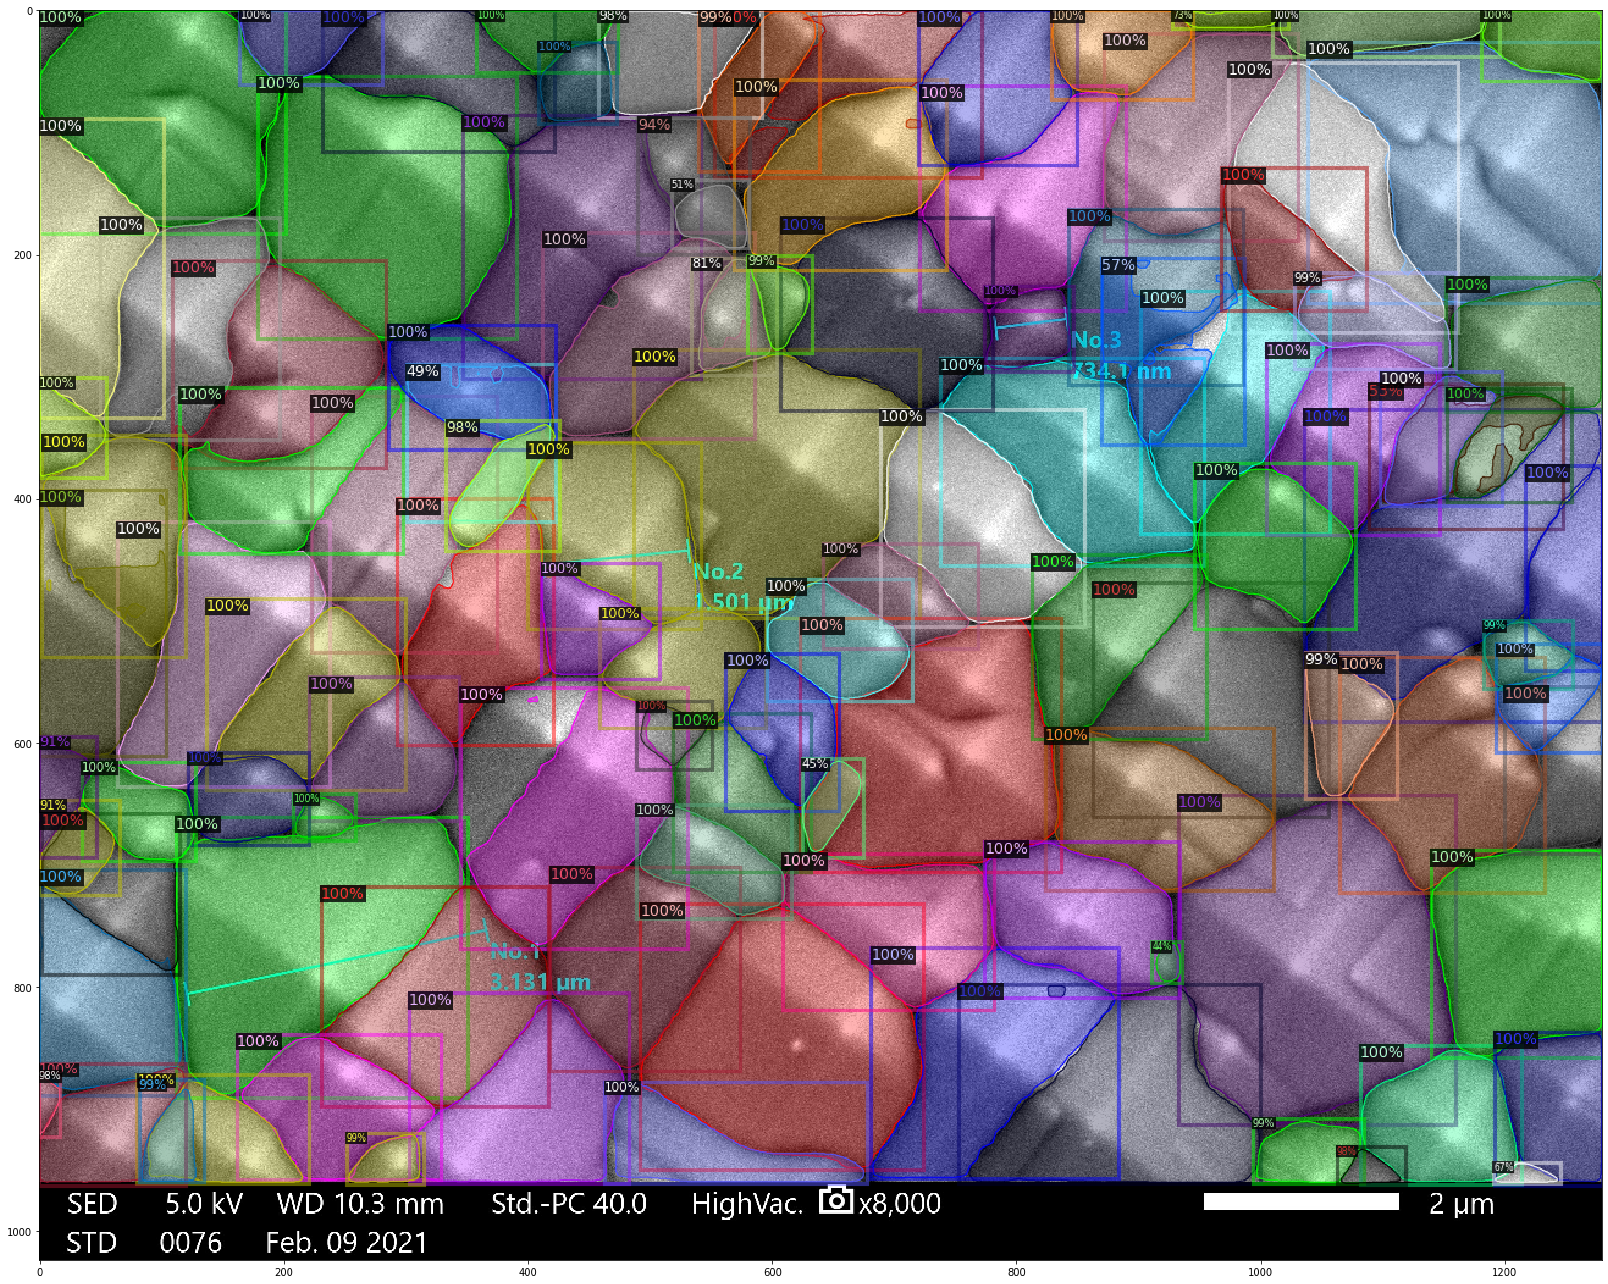

In [66]:
plt.figure(figsize = (28, 28))
plt.imshow(detectron.display_result())